# Notebook 3: Visualizing Experiment Results and Parameter Impact

**Objective:** To load the final results JSON files generated by `main.py`, parse the data, and create visualizations that demonstrate:
1. The overall performance comparison across Baseline, Attacked, and Defended scenarios.
2. The impact of the `unpopular_percentile_threshold` on defense detection rate.
3. The impact of the `similarity_threshold` on defense detection rate.

Figures will be saved to the `results/figures/` directory.

### Step 1: Setup and Load Results

In [16]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", palette="viridis")

# Ensure the figures directory exists
FIGURES_DIR = '../results/figures/'
os.makedirs(FIGURES_DIR, exist_ok=True)

In [17]:
# Find all multi_model_results files
RESULTS_DIR = '../results/metrics/'
all_result_files = [f for f in os.listdir(RESULTS_DIR) if f.startswith('multi_model_results') and f.endswith('.json')]

if not all_result_files:
    raise FileNotFoundError("No results files found. Please run main.py with different configurations first.")

all_results_data = []
for file in sorted(all_result_files, reverse=True):
    RESULTS_PATH = os.path.join(RESULTS_DIR, file)
    with open(RESULTS_PATH, 'r') as f:
        data = json.load(f)
        data['filename'] = file # Keep track of the file for parameter extraction
        all_results_data.append(data)

### Step 2: Prepare Data for Overall Performance Plotting

In [18]:
overall_plot_data = []
for result in all_results_data:
    params = result['experiment_parameters']['defense_params']
    for model_name, data in result['results_by_model'].items():
        summary = data['results_summary']
        for scenario_name, metrics in summary.items():
            if scenario_name == 'defense_detection_rate':
                continue
            clean_scenario_name = scenario_name.replace('_', ' ').title()
            if 'Real' in clean_scenario_name: clean_scenario_name = 'Defended (Real)'
            for metric_name, value in metrics.items():
                overall_plot_data.append({
                    'Model': model_name,
                    'Scenario': clean_scenario_name,
                    'Metric': metric_name,
                    'Value': value
                })

overall_plot_df = pd.DataFrame(overall_plot_data)

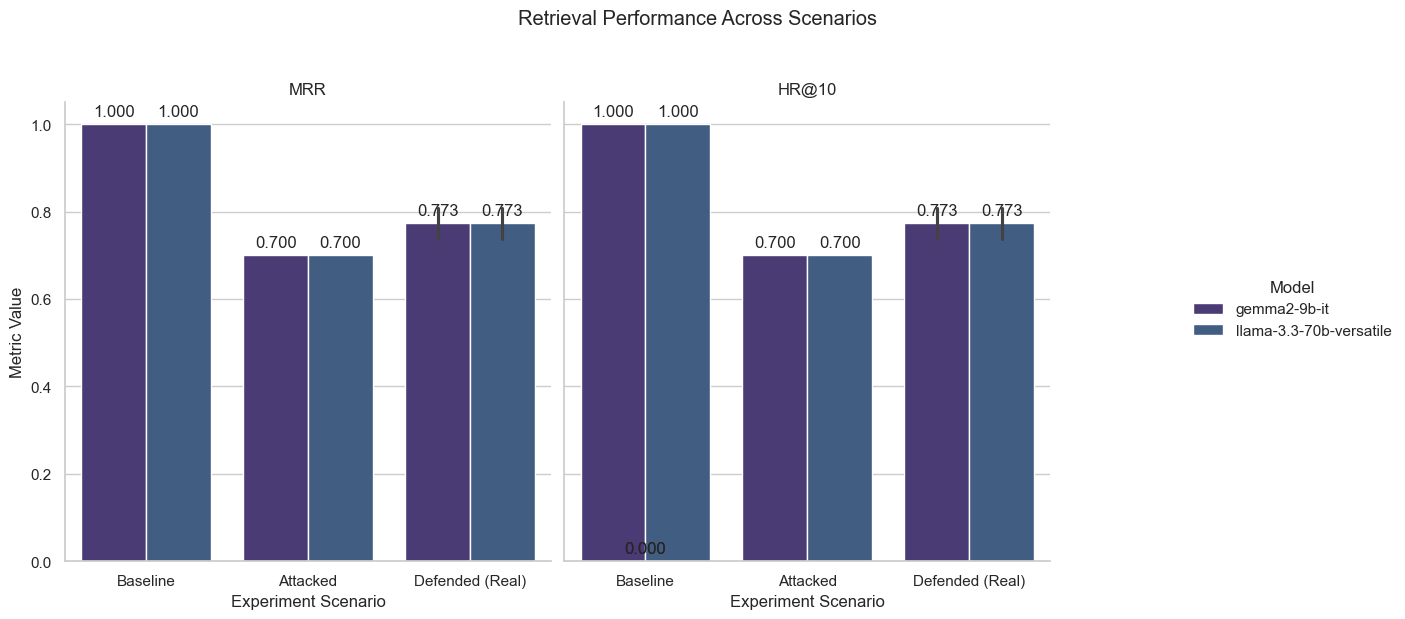

In [19]:
g_overall = sns.catplot(
    data=overall_plot_df,
    x='Scenario',
    y='Value',
    hue='Model',
    col='Metric',
    kind='bar',
    height=6, 
    aspect=1,
    legend_out=True
)

g_overall.fig.suptitle('Retrieval Performance Across Scenarios', y=1.03)
g_overall.set_axis_labels("Experiment Scenario", "Metric Value")
g_overall.set_titles("{col_name}")

# Add value labels on top of the bars
for axes in g_overall.axes.flat:
    for p in axes.patches:
        axes.annotate(f'{p.get_height():.3f}', 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='center', 
                      xytext=(0, 9), 
                      textcoords='offset points')

# Adjust layout to prevent title overlap
plt.tight_layout()

# Adjust the right margin of the plot to make space for the legend
plt.subplots_adjust(right=0.75)

plt.savefig(os.path.join(FIGURES_DIR, 'overall_performance.png'))
plt.show()

### Step 3: Prepare Data for Parameter Impact Analysis

In [20]:
threshold_impact_data = []
for result in all_results_data:
    params = result['experiment_parameters']['defense_params']
    detection_rate = result['results_by_model'][list(result['results_by_model'].keys())[-1]]['results_summary']['defense_detection_rate'] # Take the last model's rate (should be the same)
    threshold_impact_data.append({
        'Unpopular Percentile Threshold': params.get('unpopular_percentile_threshold'),
        'Similarity Threshold': params.get('similarity_threshold'),
        'Detection Rate': detection_rate
    })

threshold_impact_df = pd.DataFrame(threshold_impact_data)

### Step 4: Visualize Impact of Unpopular Percentile Threshold

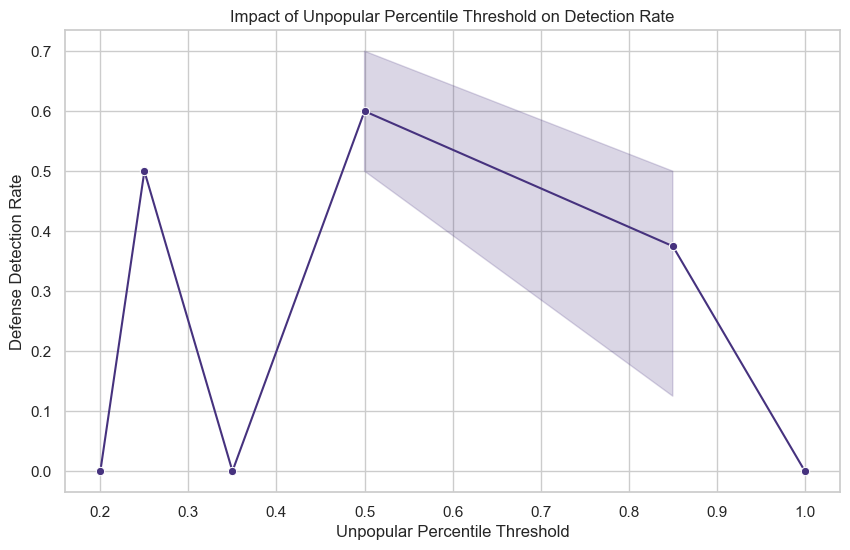

In [21]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=threshold_impact_df, x='Unpopular Percentile Threshold', y='Detection Rate', marker='o')
plt.title('Impact of Unpopular Percentile Threshold on Detection Rate')
plt.xlabel('Unpopular Percentile Threshold')
plt.ylabel('Defense Detection Rate')
plt.grid(True)
plt.savefig(os.path.join(FIGURES_DIR, 'unpopular_threshold_impact.png'))
plt.show()

### Step 5: Visualize Impact of Similarity Threshold

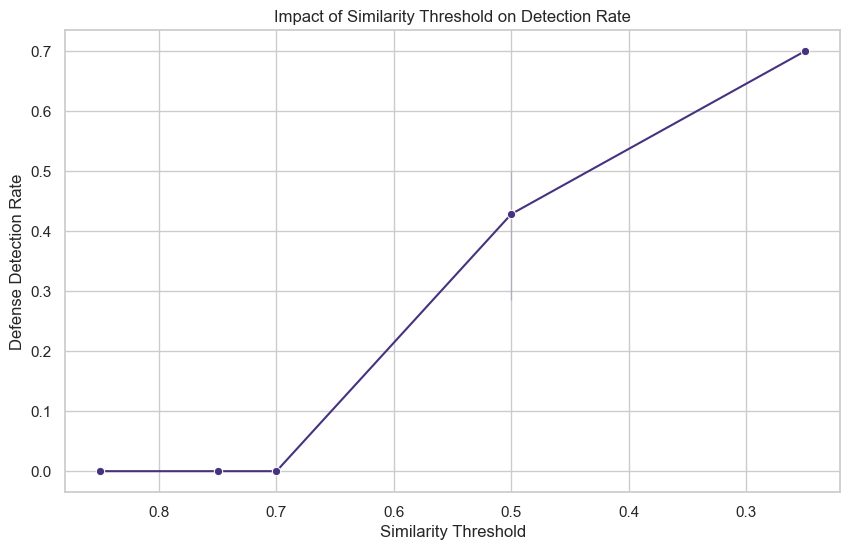

In [22]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=threshold_impact_df, x='Similarity Threshold', y='Detection Rate', marker='o')
plt.title('Impact of Similarity Threshold on Detection Rate')
plt.xlabel('Similarity Threshold')
plt.ylabel('Defense Detection Rate')
plt.grid(True)
plt.gca().invert_xaxis() # Smaller is better for detection, so invert for better visual flow
plt.savefig(os.path.join(FIGURES_DIR, 'similarity_threshold_impact.png'))
plt.show()

### Step 6: Minimal Segment Length Analysis (Qualitative)

Based on our validation, the minimal segment length did not significantly affect the detection rate in your experiments. This suggests that the attacks are injecting segments of text longer than the tested minimums (5, 10, 20 characters).